In [1]:
%matplotlib inline

## Methodology

This document records a fault detection of zone CO2 balance using Extended Kalman Filter (EKF). EKF provides possitiblities for recursive parameter and state estimations.

Assume the room, outdoor and HVAC air pressures are at equilibrium and ingnore interzone air flows. By using mass balance, the concentration of indoor CO2 is goverened by:
$$ dC_{room} = (C_{out}-C_{room})\frac{\dot{q}_{infil}}{V_{room}} + (C_{supply}-C_{room})\frac{\dot{q}_{supply}}{V_{room}} + N_{occu}\frac{\dot{G}_{gen}}{V_{room}}$$


$C_{room}$, $C_{out}$ and $C_{supply}$ are the room, outdoor and supply air CO2 concentrations respectively. $\dot{q}_{infil}$ is the infiltration flow rate, $\dot{q}_{supply}$ is the supply air flow rate. $N_{occu}$ is the number of occupants and $\dot{G}_{gen}$ is the average CO2 generation rate of a person. $V_{room}$ is the volumn of the room.

Usually $C_{room}$, $C_{supply}$ and $Q_{supply}$ are measured, $C_{out}$ is available from the weather data. $\dot{G}_{gen}$ is known for typical office work at $0.25L/min$. $V_{room}$ is not usually available to a controller, unless BIM is integrated, which is assumed to be unavailable in this case. $\dot{q_{infil}}$ is usually unknown as well. $N_{occu}$ is usually unknown but state of occupancy $S_{occu}$ is typically available through occupancy sensor.

Then discretize the function, and adding some artificial parameter terms, we have:
$$C_{room,t+\Delta t} = C_{room,t} - C_{room,t}\frac{\dot{q_{infil,t}}\Delta t}{V_{room}} + C_{out,t}\frac{\dot{q_{infil,t}}\Delta t}{V_{room}} - C_{room,t}\dot{q}_{supply,t}\frac{\Delta t}{V_{room}} + C_{supply,t}\dot{q}_{supply,t}\frac{\Delta t}{V_{room}} + S_{occu,t}\frac{\dot{V}_{gen}N_{occu,t}\Delta t}{V_{room}}$$

Then the function can be further reduced to:
$$C_{room,t+\Delta t} = C_{room,t} - C_{room,t}p_{1,t} + C_{out,t}p_{1,t} - C_{room,t}\dot{q}_{supply,t}p_{2,t} + C_{supply,t}\dot{q}_{supply,t}p_{2,t} + S_{occu,t}p_{3,t}$$


The state and parameter extimate vector x, is:
$$ x = \left[\begin{array}
{r}
C_{room} \\
p_1 \\
p_2 \\
p_3
\end{array}\right]
=
\left[\begin{array}
{r}
x_1 \\
x_2 \\
x_3 \\
x_4
\end{array}\right]$$

Input vector u, is:
$$ u = 
\left[\begin{array}
{r}
C_{out} \\
C_{supply} \\
\dot{q}_{supply} \\
S_{occu} \\
\end{array}\right]
=
\left[\begin{array}
{r}
u_1 \\
u_2 \\
u_3 \\
u_4
\end{array}\right]
$$

## Filter Setup

The volumn of this room is $61.6 m^3$, and outdoor air CO2 concentration is assumed to be $420 ppm$ constant. The CO2 generation rate of the occupant is $3.82*10^{-6} m^3/s$. There is only one occupant and the infiltration rate is 1 ACH. Simulation timestep is 5 mins.

With a 15min timestep, the theoretical values for the parameters are:
$$ x = \left[\begin{array}
{r}
C_{room} \\
0.083 \\
4.867 \\
29.917
\end{array}\right]
$$

The EKF class is already created. All that need to do is to use sympy to create symbolic x, u vectors and the function vector so that the Jacobian matrix inside the EKF can be calculated automatically.

Another advantage to use sympy is that it can 'lambdify' its functions, so the substitution and matrix manipulation can be calculated very efficiently.

In [42]:
import numpy as np
import sympy
import library.EKF as EKF
import pandas as pd

In [43]:
#Creating sympy symbols
x1, x2, x3, x4, u1, u2, u3, u4 = sympy.symbols('x1 x2 x3 x4 u1 u2 u3 u4')
#Creating x and u vector, unlike numpy, sympy creates column vector automatically
X = sympy.Matrix([x1, x2, x3, x4])
U = sympy.Matrix([u1, u2, u3, u4])
print(X)

Matrix([[x1], [x2], [x3], [x4]])


In [44]:
#Set up the sympy function
fun = sympy.Matrix([
    x1 - x2*x1 + u1*x2 - x1*u3*x3 + u2*u3*x3 + u4*x4,
    x2,
    x3,
    x4
])
print(fun)

Matrix([[u1*x2 + u2*u3*x3 - u3*x1*x3 + u4*x4 - x1*x2 + x1], [x2], [x3], [x4]])


In [85]:
P = np.eye(4)
q = np.array([3.0, 0.0, 0.0, 0.0])[np.newaxis]
Q = q.T * q
print(Q)
#Measuremen covariance, values are very small for parameter estimates
R = np.matrix([[5,1,3,2],[0.002,0.001,0.003,0.002],[0.02,0.04,0.04,0.02],[0.01,0.02,0.02,0.05]])
H = sympy.Matrix([x1, 0, 0, 0])

[[ 9.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]


In [86]:
#Import the data as a pandas dataframe
data = pd.read_csv('data/EP_CO2.csv')
#Initial conditions doesn't have to be precise
state_estimates = np.matrix([[data["ZoneCO2"][0]],
                             [0.08],
                             [5.0],
                             [30.3]])
co2_ekf = EKF.ExtendedKalmanFilter(fun, X, U, P, Q, H, R, state_estimates)

In [49]:
#Observe EKF Jacobian calculated using sympy
print(co2_ekf.F)

Matrix([[-u3*x3 - x2 + 1, u1 - x1, u2*u3 - u3*x1, u4], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])


In [50]:
#Try a first prediction
#generate control vector
C_out = 420
C_supply = data["SupplyCO2"][0]
Q_supply = data["SupplyFlow"][0]
OCC = data["OCCU"][0]
controls = np.matrix([[C_out], [C_supply], [Q_supply], [OCC]])
co2_ekf.predict(controls)
print(co2_ekf.X_values)

[[  4.20122874e+02]
 [  8.00000000e-02]
 [  5.00000000e+00]
 [  3.03000000e+01]]


## Experiment Setup

Sensor noise are also assumed and injected, CO2 sensors has a Gaussian noise with $10ppm$ std, and flow rate readings, typically coming from square root of a pressure reading and kfactor conversion, has a Gaussian noise with $0.001 m^3/s$.

In [72]:
predicted = []
actual = []
measured = []
estimates = []
p1 = []
p2 = []
p3 = []
length = data.shape[0]
iterations = length
#setting up sensor noises
np.random.seed(1234)
zoneCO2_noise = np.random.normal(0,10,iterations)
supplyCO2_noise = np.random.normal(0,10,iterations)
supplyflow_noise = np.random.normal(0,0.001,iterations)

In [73]:
for i in range(1, iterations):
    #generate control vector
    C_out = 420
    C_supply = data["SupplyCO2"][i-1] + supplyCO2_noise[i-1]
    Q_supply = data["SupplyFlow"][i-1] + supplyflow_noise[i-1]
    OCC = data["OCCU"][i-1]
    controls = np.matrix([[C_out], [C_supply], [Q_supply], [OCC]])

    #prediction
    co2_ekf.predict(controls)
    predicted.append(co2_ekf.X_values[0,0])
    estimates.append(co2_ekf.X_values.T.reshape(-1,).tolist())
    p1.append(co2_ekf.X_values[1,0])
    p2.append(co2_ekf.X_values[2,0])
    p3.append(co2_ekf.X_values[3,0])

    #update
    meas = data["ZoneCO2"][i] + zoneCO2_noise[i]
    actual.append(data["ZoneCO2"][i])
    measured.append(meas)
    co2_ekf.update(np.matrix([[meas],[0],[0],[0]]))

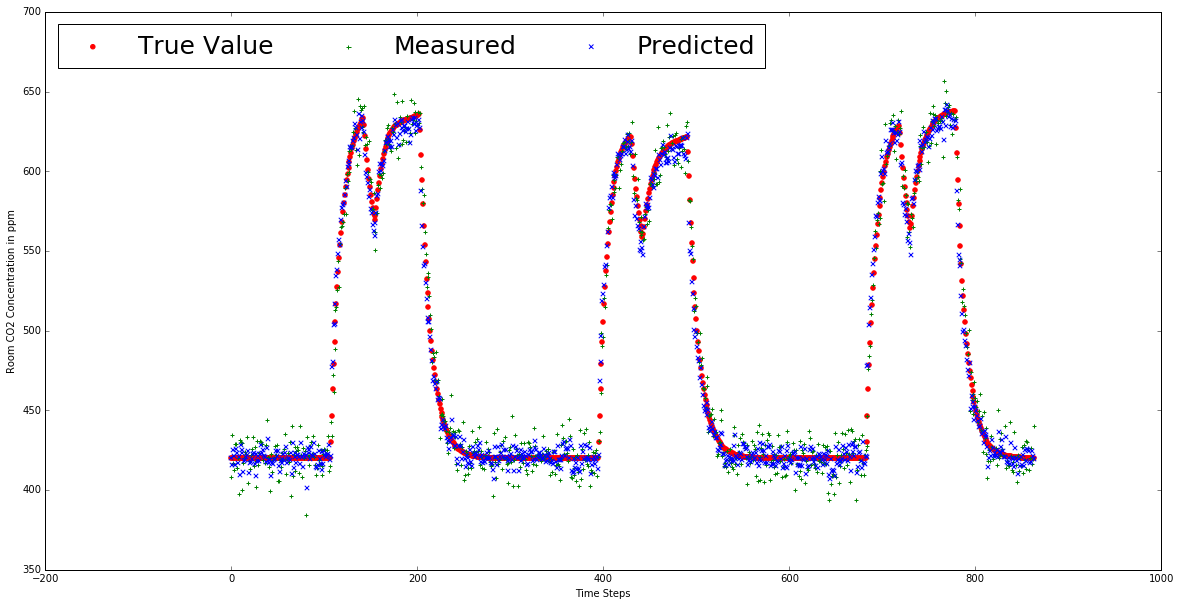

In [83]:
import matplotlib.pyplot as plt
#plotting first three days of prediction results
plot_len = (3*24*12)
x = np.arange(plot_len)
plt.figure(figsize=(20,10))
tru = plt.scatter(x, actual[0:plot_len], color="r", marker="o")
mea = plt.scatter(x, measured[0:plot_len], color="g", marker = "+")
pre = plt.scatter(x, predicted[0:plot_len], color="b", marker="x")
plt.legend((tru,mea,pre),
           ("True Value","Measured", "Predicted"),
            scatterpoints = 1,
            ncol = 3,
            fontsize=25,
            loc="upper left")
plt.xlabel("Time Steps")
plt.ylabel("Room CO2 Concentration in ppm")
plt.show()

In [81]:
print('P1 ideal value is 0.083, estimated average is {0} and std is {1} '.format(np.mean(p1),np.std(p1)))
print('P2 ideal value is 4.867, estimated average is {0} and std is {1} '.format(np.mean(p2),np.std(p2)))
print('P2 ideal value is 29.917, estimated average is {0} and std is {1} '.format(np.mean(p3),np.std(p3)))

P1 ideal value is 0.083, estimated average is 0.184272438018401 and std is 0.00607386038142731 
P2 ideal value is 4.867, estimated average is 11.769660814125755 and std is 0.09290884929086916 
P2 ideal value is 29.917, estimated average is 42.491116423376376 and std is 1.0369059208231024 
